In [2]:
#This code is only re-written by me to understand, with slight modifications.
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
import six
import sys
sys.modules['sklearn.externals.six']=six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [3]:
data = pd.read_csv("training_variants")
print("Number of features: ",data.shape[1])
print("Number of data points: ",data.shape[0])
data.head()

Number of features:  4
Number of data points:  3321


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
data_text = pd.read_csv('training_text',sep='\|\|',engine='python',names=['ID','TEXT'],skiprows=1)
print("Number of features: ",data_text.shape[1])
print("Number of data points: ",data_text.shape[0])
print("Feature names: ",data_text.columns.values)
data_text.head()

Number of features:  2
Number of data points:  3321
Feature names:  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hatyy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#loading stopwords from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string=''
        #replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        #replace multiple spaces with single space
        total_text = re.sub('\s+',' ',total_text)
        #converting all the chars into lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            #if word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        data_text[column][index] = string
        

In [7]:
#text processing stage
start_time = time.process_time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id: ",index)
print("Time took for preprocessing the text: ",time.process_time()-start_time, 'Seconds')

There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755
Time took for preprocessing the text:  49.890625 Seconds


In [8]:
#merging both gene_variants and text data based on ID
result =pd.merge(data,data_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result[result.isnull().any(axis=1)]


,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']


In [11]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [12]:
#train, test and cross validation split
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

#split the data into test and train by maintaining same distribution of output variable 'y_true'[stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true,test_size=0.2)
#split the data into train and cross validation by maintaining same distribution of output variable ''y_train''[stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [13]:
print("Number of data points in train data: ",train_df.shape[0])
print("Number of data points in test data: ",test_df.shape[0])
print("Number of data points in cross validation: ",cv_df.shape[0])

Number of data points in train data:  2124
Number of data points in test data:  665
Number of data points in cross validation:  532


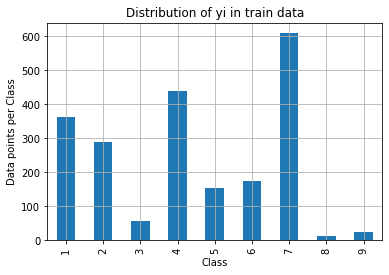

Number of data points in class:  7 : 609 ( 28.672 %)
Number of data points in class:  4 : 439 ( 20.669 %)
Number of data points in class:  1 : 363 ( 17.09 %)
Number of data points in class:  2 : 289 ( 13.606 %)
Number of data points in class:  6 : 176 ( 8.286 %)
Number of data points in class:  5 : 155 ( 7.298 %)
Number of data points in class:  3 : 57 ( 2.684 %)
Number of data points in class:  9 : 24 ( 1.13 %)
Number of data points in class:  8 : 12 ( 0.565 %)
--------------------------------------------------


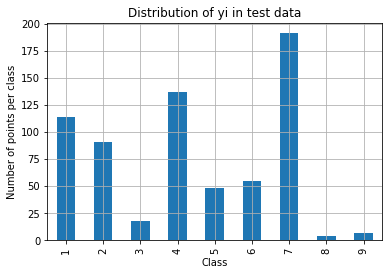

Number of data points in class:  7 : 191 ( 28.722 %)
Number of data points in class:  4 : 137 ( 20.602 %)
Number of data points in class:  1 : 114 ( 17.143 %)
Number of data points in class:  2 : 91 ( 13.684 %)
Number of data points in class:  6 : 55 ( 8.271 %)
Number of data points in class:  5 : 48 ( 7.218 %)
Number of data points in class:  3 : 18 ( 2.707 %)
Number of data points in class:  9 : 7 ( 1.053 %)
Number of data points in class:  8 : 4 ( 0.602 %)
--------------------------------------------------


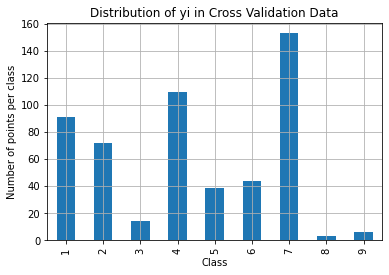

Number of data points in class:  7 : 153 ( 28.759 %)
Number of data points in class:  4 : 110 ( 20.677 %)
Number of data points in class:  1 : 91 ( 17.105 %)
Number of data points in class:  2 : 72 ( 13.534 %)
Number of data points in class:  6 : 44 ( 8.271 %)
Number of data points in class:  5 : 39 ( 7.331 %)
Number of data points in class:  3 : 14 ( 2.632 %)
Number of data points in class:  9 : 6 ( 1.128 %)
Number of data points in class:  8 : 3 ( 0.564 %)


In [14]:
#Distribution of y_i's in train, test and cross validatation data
#It returns a dict, keys as class label and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel("Data points per Class")
plt.title("Distribution of yi in train data")
plt.grid()
plt.show()
sorted_yi=np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class: ",i+1,':',train_class_distribution.values[i],'(',np.round((train_class_distribution.values[i]/train_df.shape[0]*100),3), '%)')

print('-'*50)
my_colors ='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of points per class")
plt.title("Distribution of yi in test data")
plt.grid()
plt.show()
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class: ",i+1,':',test_class_distribution.values[i],'(',np.round((test_class_distribution.values[i]/test_df.shape[0]*100),3),'%)')

print('-'*50)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Number of points per class")
plt.title("Distribution of yi in Cross Validation Data")
plt.grid()
plt.show()
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class: ",i+1,':',cv_class_distribution.values[i],'(',np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100),3),'%)')

In [15]:
#This function plot confusion metrics
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (((C.T)/(C.sum(axis=1))).T)
    
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion Matrix","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20,"Precision Matrix","-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True,cmap='YlGnBu',fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predcited Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20,'Recall Matrix',"-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap='YlGnBu',fmt='.3f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log Loss on Cross Validation data using Random Model:  2.4842291394231837
Log Loss on test data using random Model:  2.4751569633698325
-------------------- Confusion Matrix --------------------


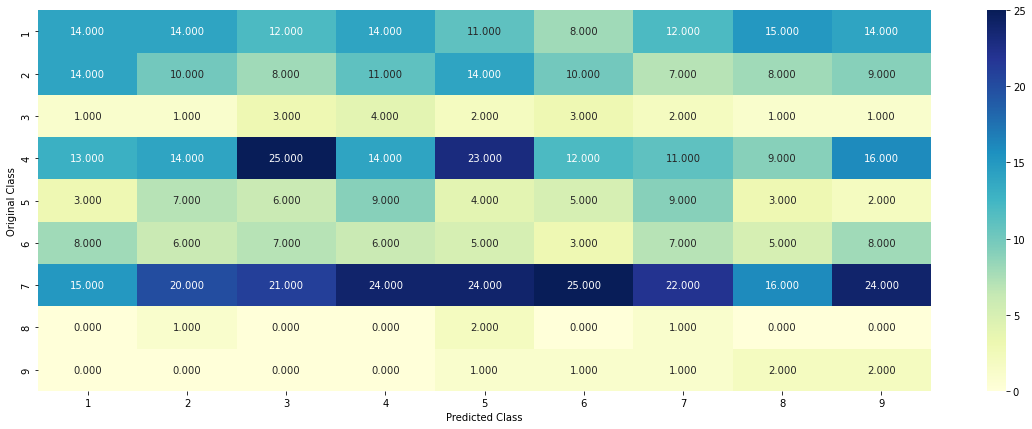

-------------------- Precision Matrix --------------------


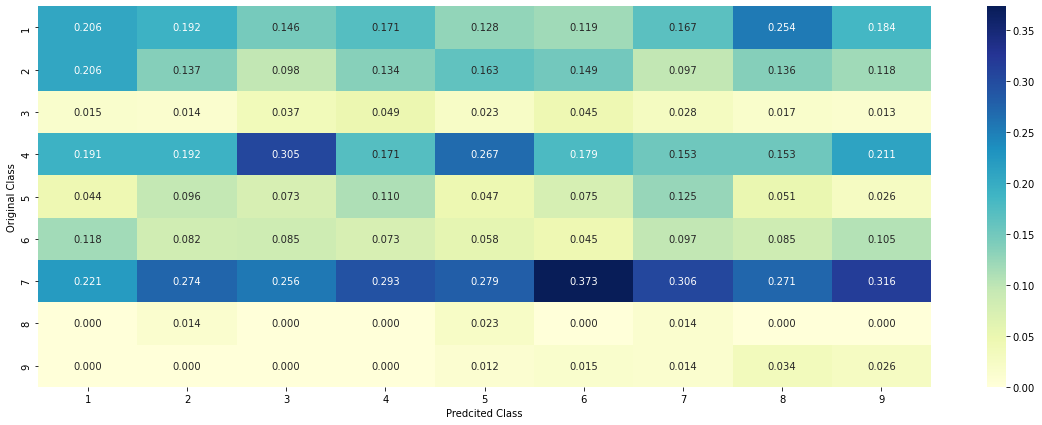

-------------------- Recall Matrix --------------------


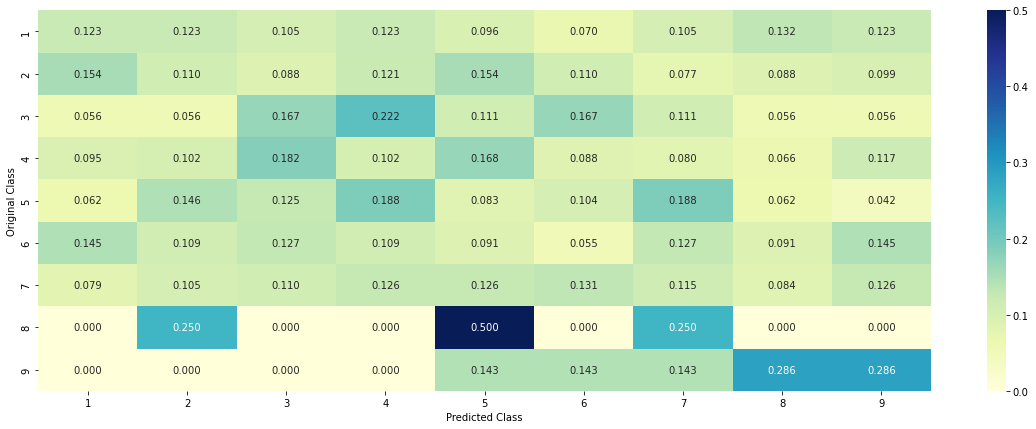

In [16]:
#Random Model
#We need to generate 9 numbers and the sum of numbers should be 1
#one solution is to generate 9 numbers and divide each of the numbers by their sum
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]
#we create a output array that has exactly same size of the cv data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on Cross Validation data using Random Model: ",log_loss(y_cv,cv_predicted_y,eps=1e-15))

#Test Error
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on test data using random Model: ",log_loss(y_test,test_predicted_y,eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [17]:
#Univariate Analysis
#get_gv_fea_dict: Get Gene variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/(denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
    

In [18]:
unique_genes = train_df['Gene'].value_counts()
print("Number of Unique Genes: ",unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes:  231
BRCA1     168
TP53      106
EGFR       89
PTEN       85
BRCA2      84
KIT        66
BRAF       61
ERBB2      44
ALK        43
PDGFRA     37
Name: Gene, dtype: int64


In [19]:
print("Ans:  There are",unique_genes.shape[0],'different categories of genes in the train data, and they are distributed as follows')

Ans:  There are 231 different categories of genes in the train data, and they are distributed as follows


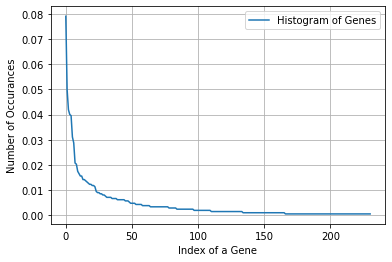

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histogram of Genes")
plt.xlabel("Index of a Gene")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

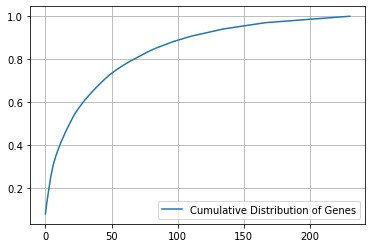

In [21]:
c =np.cumsum(h)
plt.plot(c,label="Cumulative Distribution of Genes")
plt.grid()
plt.legend()
plt.show()

In [22]:
#response coding of the Gene feature
#alpha is used for laplace smoothing
alpha=1
#train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
#test gene feature 
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha,"Gene", test_df))
#cv gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha,"Gene",cv_df))

In [23]:
print("train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature: ",train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:  (2124, 9)


In [24]:
#one hot encoding of gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df["Gene"])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df["Gene"])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df["Gene"])

In [25]:
train_df['Gene'].head()

3057       KIT
3233     NTRK2
1315      MLH1
2720      BRAF
3075    NOTCH1
Name: Gene, dtype: object

In [26]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurkb',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ja

In [27]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of Gene feature: ",train_gene_feature_onehotCoding.shape)
print("test_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of Gene feature: ",test_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of Gene feature:  (2124, 231)
test_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of Gene feature:  (665, 231)


For values alpha =  1e-05 The log loss is:  1.18905258300824
For values alpha =  0.0001 The log loss is:  1.1650307660411205
For values alpha =  0.001 The log loss is:  1.213433218348863
For values alpha =  0.01 The log loss is:  1.3316832542848676
For values alpha =  0.1 The log loss is:  1.4017527760423123
For values alpha =  1 The log loss is:  1.4371737726186133


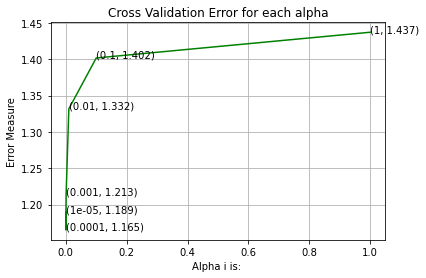

For values of best alpha:  0.0001 The train log loss is:  0.9894418202794234
For values of best alpha:  0.0001 The cross validation log loss is:  1.1650307660411205
For values of best alpha:  0.0001 The test log loss is:  1.214234050120399


In [28]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2',loss='log',random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print("For values alpha = ",i,"The log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i is: ")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha], "The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha], "The cross validation log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha], "The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [29]:
print("How many data points in Test and CV datasets are covered by the ",unique_genes.shape[0],"in train dataset?")
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df["Gene"])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print("Ans\n1. In test data",test_coverage,'out of',test_df.shape[0],":",(test_coverage/test_df.shape[0])*100)
print("2. In Cross Validation data",cv_coverage,'out of', cv_df.shape[0],':',(cv_coverage/cv_df.shape[0])*100)

How many data points in Test and CV datasets are covered by the  231 in train dataset?
Ans
1. In test data 646 out of 665 : 97.14285714285714
2. In Cross Validation data 511 out of 532 : 96.05263157894737


In [30]:
#Univariate analysis on Variation feature
#Q: Variation, What type of feature is it?
#Ans: Variation is a categorical variable
#How many categories are there?
unique_variations=train_df['Variation'].value_counts()
print("Number of Unique Variation: ",unique_variations.shape[0])
unique_variations.head()


Number of Unique Variation:  1926


Truncating_Mutations    66
Deletion                48
Amplification           42
Fusions                 21
Overexpression           4
Name: Variation, dtype: int64

In [31]:
print("Ans: There are",unique_variations.shape[0],"different categories of Variation in Train data and they are distributed as follows")

Ans: There are 1926 different categories of Variation in Train data and they are distributed as follows


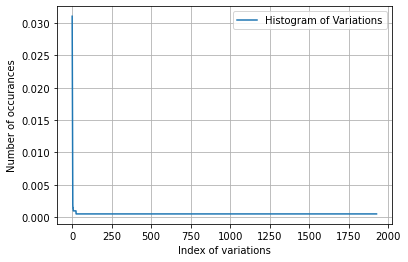

In [32]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label='Histogram of Variations')
plt.xlabel("Index of variations")
plt.ylabel("Number of occurances")
plt.legend()
plt.grid()
plt.show()

[0.03107345 0.05367232 0.07344633 ... 0.99905838 0.99952919 1.        ]


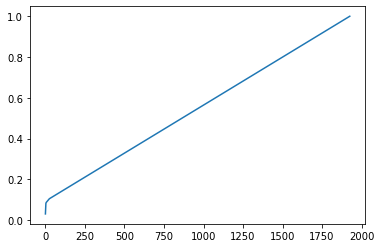

In [33]:
c = np.cumsum(h)
print(c)
plt.plot(c,label="Cumulative Distribution of Variations")
plt.grid()
plt.grid()
plt.show()

In [34]:
#Featurize Variation feature
alpha=1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responceCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [35]:
print('train_variation_feature_responseCoding is converted feature using the response coding method. The shape of Variation feature:',train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [36]:
#one hot encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [37]:
print("train_variation_feature_onehotCoding is converted feature using the one hot encoding method. The shape of Variation feature: ",train_variation_feature_onehotCoding.shape)
print("test_variation_feature_onehotCoding is converted feature using the one hot encoding method. The shape of Variation feature: ",test_variation_feature_onehotCoding.shape)

train_variation_feature_onehotCoding is converted feature using the one hot encoding method. The shape of Variation feature:  (2124, 1957)
test_variation_feature_onehotCoding is converted feature using the one hot encoding method. The shape of Variation feature:  (665, 1957)


For values of alpha=  1e-05 The log loss is:  1.708727287269548
For values of alpha=  0.0001 The log loss is:  1.7052414221001886
For values of alpha=  0.001 The log loss is:  1.712188412473917
For values of alpha=  0.01 The log loss is:  1.7249777440832328
For values of alpha=  0.1 The log loss is:  1.7373821248840056
For values of alpha=  1 The log loss is:  1.738006814026754


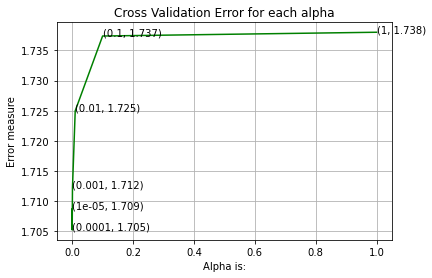

For values of best alpha:  0.0001 The train log loss is:  0.6464365724398139
For values of best alpha:  0.0001 The cross validation log loss is:  1.7052414221001886
For valus of best alpha:  0.0001 The test log loss is:  1.7215976758808593


In [38]:
#How good is this Variation feature in predicting yi?
#Ans: Lets build a model just like earlier
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2',loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print("For values of alpha= ",i, "The log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i], np.round(txt,3)),(alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha is:")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],'The cross validation log loss is: ',log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print("For valus of best alpha: ",alpha[best_alpha],"The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [39]:
#is variation feature stable accross all the data sets?(Test, Train, Cross Validation)
#Ans: Not sure! But lets be very sure using the below analysis
print("Q.12: How many data points are covered by total",unique_variations.shape[0],'variations in test and cross validation data sets?')
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print("Ans: \n1: in Test data",test_coverage,'out of',test_df.shape[0],":",(test_coverage/test_df.shape[0])*100)
print("In Cross Validation data",cv_coverage,'out of',cv_df.shape[0],':',(cv_coverage/cv_df.shape[0])*100)

Q.12: How many data points are covered by total 1926 variations in test and cross validation data sets?
Ans: 
1: in Test data 62 out of 665 : 9.323308270676693
In Cross Validation data 55 out of 532 : 10.338345864661653


In [40]:
#Univariate analysis on Text Feature
#1. How many unique words are present in train data?
#2. How are word frequencies distributed?
#3. How to featurize text field?
#4. is the text feature useful in predicting yi?
#5. Is the text feature stable accross train, test and CV datasets?

In [41]:
#for every row in data frame consider the "TEXT"
#split the words by space
#make a dict with those words
#increment its count whenever we see that word
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [42]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row["TEXT"].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i]= math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [43]:
#building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
#getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()
#train_text_feature_onehotCoding.sum(axis=0). A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data: ",len(train_text_features))

Total number of unique words in train data:  53822


In [44]:
dict_list = []
#dict_list=[] contains 9 dictionaries each crossponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    #build a word dict based on word in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    #append it to dict_list
#dict_list[i] is build on i'th class text data
#total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios=[]
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10)/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [45]:
#response coding of text feature
train_text_feature_responseCoding = get_text_responsecoding(train_df)
test_text_feature_responseCoding = get_text_responsecoding(test_df)
cv_text_feature_responseCoding = get_text_responsecoding(cv_df)

In [46]:
#we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [47]:
#dont forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
#we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df["TEXT"])
#dont forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
#we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df["TEXT"])
#dont forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [48]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(),key=lambda x: x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [49]:
#numbr of words in given freqency
print(Counter(sorted_text_occur))

Counter({3: 5699, 4: 3267, 5: 3056, 6: 2824, 7: 2574, 8: 1802, 9: 1589, 10: 1527, 11: 1269, 12: 1197, 13: 1059, 14: 896, 15: 817, 16: 793, 18: 739, 20: 665, 17: 660, 22: 567, 24: 512, 19: 475, 21: 455, 30: 435, 25: 365, 23: 359, 42: 358, 28: 356, 32: 355, 27: 355, 26: 327, 33: 297, 29: 283, 31: 270, 36: 269, 55: 246, 34: 243, 35: 236, 39: 223, 40: 213, 46: 202, 44: 199, 37: 198, 48: 184, 45: 182, 38: 175, 41: 170, 43: 168, 50: 163, 49: 159, 54: 150, 57: 149, 47: 148, 56: 144, 60: 141, 53: 137, 52: 131, 51: 131, 58: 129, 61: 127, 72: 123, 66: 120, 64: 114, 73: 112, 63: 112, 65: 105, 71: 103, 62: 101, 68: 99, 59: 99, 69: 98, 67: 96, 84: 94, 92: 88, 78: 87, 70: 87, 74: 84, 90: 81, 80: 80, 79: 76, 76: 76, 85: 75, 77: 75, 88: 73, 81: 73, 75: 69, 82: 66, 97: 65, 91: 65, 110: 63, 105: 61, 86: 61, 87: 60, 108: 59, 89: 58, 112: 57, 98: 57, 100: 56, 94: 56, 83: 56, 96: 54, 93: 54, 117: 53, 101: 53, 104: 52, 99: 51, 95: 50, 111: 49, 127: 46, 116: 46, 109: 46, 107: 46, 135: 45, 136: 44, 122: 44, 1

For values of alpha 1e-05 The log loss is:  1.2445805387521063
For values of alpha 0.0001 The log loss is:  1.097737872811365
For values of alpha 0.001 The log loss is:  1.1032599977664095
For values of alpha 0.01 The log loss is:  1.2297897991790585
For values of alpha 0.1 The log loss is:  1.4141662569979745
For values of alpha 1 The log loss is:  1.6473884352183457


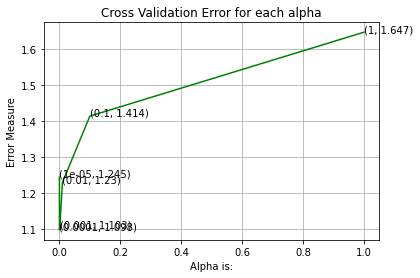

For values of best alpha:  0.0001 The train log loss is:  0.6705884229691812
For values of best alpha:  0.0001 The cross validation log loss is 1.097737872811365
For values of best alpha:  0.0001 The test log loss is:  1.2466156302918856


In [50]:
#train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5,1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y,labels=clf.classes_, eps=1e-15))
    print("For values of alpha",i, "The log loss is: ", log_loss(y_cv,predict_y, labels=clf.classes_,eps=1e-15))
fig, ax= plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha is:")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2', loss='log',random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The cross validation log loss is",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print("For values of best alpha: ", alpha[best_alpha],"The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [51]:
#Q: Is the Text feature stable accross all the data sets(Train, Test, and Cross Validation)?
#Ans: Yes it seems like
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1, len2

In [52]:
len1, len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100,3),"% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100,3),'% of word of cross validation data appeared in train data')

96.821 % of word of test data appeared in train data
97.868 % of word of cross validation data appeared in train data


In [53]:
#4. Machine learning models
#Data Prepration for ML models
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    #for calculating log_loss we will provide the array of probabilities belongs to each classes
    print("Log Loss: ",log_loss(test_y, sig_clf.predict_proba(test_x)))
    #calculating the number of data points that are mis-classified:
    print("Number of mis-classified points: ",np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [54]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)


In [55]:
#This function will be used for naive bayes
#for the given indices, we will print the name of the features
#and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i, v in enumerate(indices):
        if (v< fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, 'Gene Feature [{}] present in test data point [{}]'.format(word,yes_no))
        elif (v< fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "Variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word, yes_no))
    print("Out of the top",no_features,"features",word_present,"are present in query point")

In [56]:
#Stacking the three types of features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df["Class"]))
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df["Class"]))
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [57]:
print("One Hot Encoding Features: ")
print('(Number of data points * number of features) in train data: ',train_x_onehotCoding.shape)
print('(Number of data points * number of features) in test data: ',test_x_onehotCoding.shape)
print('(Number of data points * number of features) in cv data: ', cv_x_onehotCoding.shape )

One Hot Encoding Features: 
(Number of data points * number of features) in train data:  (2124, 56010)
(Number of data points * number of features) in test data:  (665, 56010)
(Number of data points * number of features) in cv data:  (532, 56010)


In [58]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding, cv_variation_feature_responceCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [59]:
print("Response Encoding Features:")
print('(Number of data points * number of features) in train data: ',train_x_responseCoding.shape)
print('(Number of data points * number of features) in test data: ',test_x_responseCoding.shape)
print('(Number of data points * number of features) in cross validation data',cv_x_responseCoding.shape)

Response Encoding Features:
(Number of data points * number of features) in train data:  (2124, 27)
(Number of data points * number of features) in test data:  (665, 27)
(Number of data points * number of features) in cross validation data (532, 27)


For alpha:  1e-05
Log Loss :  1.2557514547789614
For alpha:  0.0001
Log Loss :  1.2525797673429782
For alpha:  0.001
Log Loss :  1.2434477997438949
For alpha:  0.1
Log Loss :  1.241824710806729
For alpha:  1
Log Loss :  1.3020177702585032
For alpha:  10
Log Loss :  1.3546847256181063
For alpha:  100
Log Loss :  1.3857155515761403
For alpha:  1000
Log Loss :  1.3392434508718094


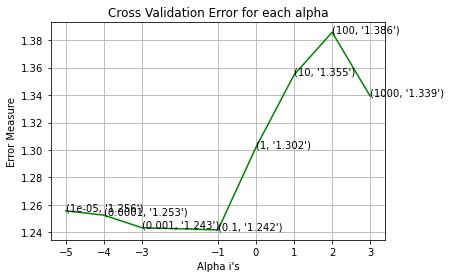

For values of best alpha:  0.1 The train log loss is:  0.849618321830917
For values of best alpha:  0.1 The cross validation log loss is:  1.241824710806729
For values of best alpha:  0.1 The test log loss is:  1.2964759419117495


In [60]:
#4.1 Base Line Model
#4.1.1 Naive Bayes
#4.1.1.1 Hyper parameter tuning
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
cv_log_error_array = []
for i in alpha:
    print("For alpha: ",i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_,eps=1e-15))
    #to avoid rounding error while multiplying probabilities we use log-probability estimates
    print("Log Loss : ",log_loss(cv_y, sig_clf_probs))
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The cross validation log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss:  1.241824710806729
Number of misclassified points:  0.39097744360902253
-------------------- Confusion Matrix --------------------


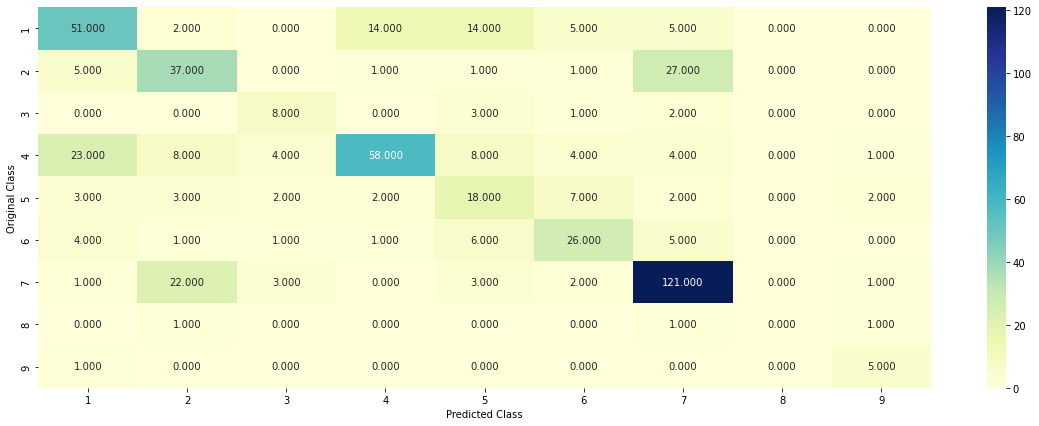

-------------------- Precision Matrix --------------------


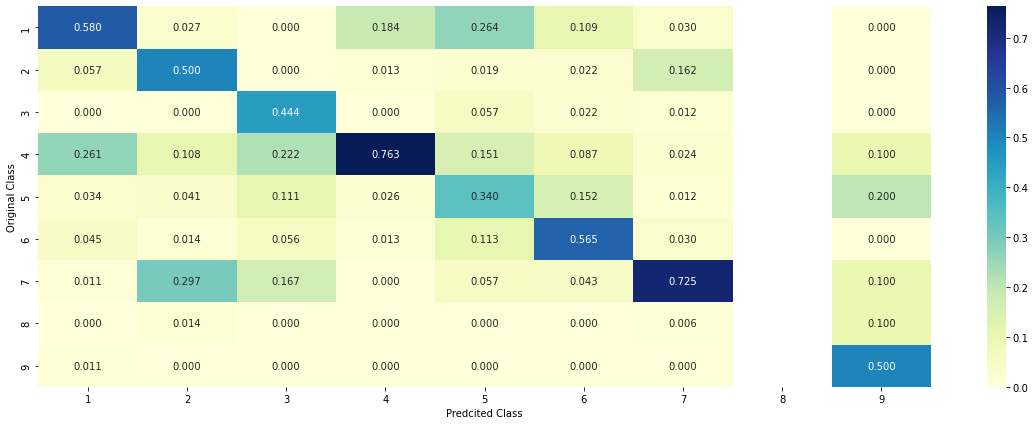

-------------------- Recall Matrix --------------------


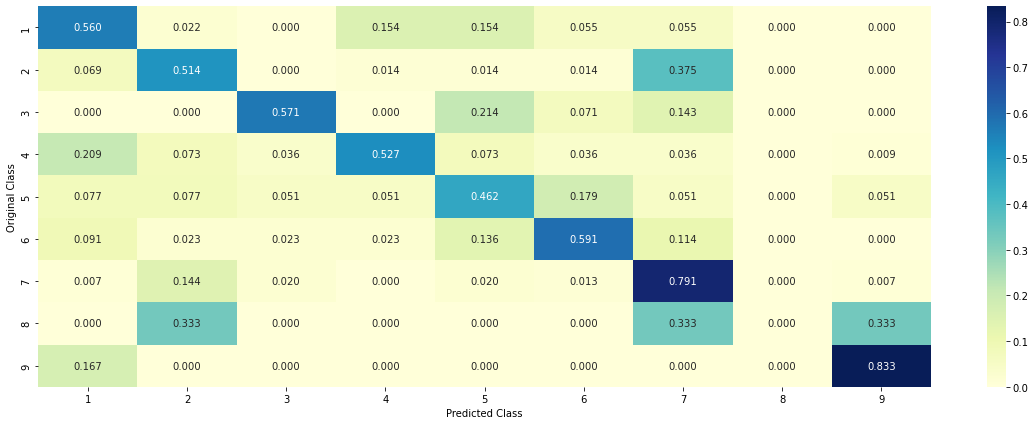

In [61]:
#Testing the model with best hyperparameter
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
#to avoid rounding error while multiplying probabilities we use log-probability estimates
print("Log loss: ",log_loss(cv_y, sig_clf_probs))
print("Number of misclassified points: ", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding) - cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [62]:
#4.1.1.3 Feature Importance, correctly classified point
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("predicted Class: ",predicted_cls[0])
print("predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class: ", test_y[test_point_index])
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print('-'*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df["Variation"].iloc[test_point_index], no_feature)

predicted Class:  1
predicted Class Probabilities:  [[0.473 0.073 0.016 0.224 0.033 0.036 0.136 0.004 0.005]]
Actual Class:  4
--------------------------------------------------
12 Text feature [dna] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [protein] present in test data point [True]
17 Text feature [type] present in test data point [True]
18 Text feature [one] present in test data point [True]
19 Text feature [two] present in test data point [True]
20 Text feature [sequence] present in test data point [True]
21 Text feature [amino] present in test data point [True]
22 Text feature [wild] present in test data point [True]
24 Text feature [possible] present in test data point [True]
27 Text feature [containing] present in test data point [True]
29 Text feature [region] present in test data point [True]
30 Text feature [four] present in test data point [True]
31 Text feature [result] present in test data point [True]
3

In [63]:
test_df["TEXT"].iloc[test_point_index]

'brca1 associated protein 1 bap1 deubiquitinating enzyme involved regulation cell growth recently many somatic germline mutations bap1 reported broad spectrum tumors study identified novel somatic non synonymous bap1 mutation phenylalanine isoleucine substitution codon 170 f170i 1 49 patients esophageal squamous cell carcinoma escc multiplex ligation dependent probe amplification mlpa bap1 gene escc tumor disclosed monoallelic deletion loh suggesting bap1 alterations alleles tumor deubiquitinase activity auto deubiquitinase activity f170i mutant bap1 markedly suppressed compared wild type bap1 addition wild type bap1 mostly localizes nucleus whereas f170i mutant preferentially localized cytoplasm microarray analysis revealed expression f170i mutant drastically altered gene expression profiles compared expressed wild type bap1 gene ontology analyses indicated f170i mutation altered expression genes involved oncogenic pathways found one candidate tceal7 previously reported putative tumor

In [64]:
no_feature

100

In [65]:
test_df["Gene"].iloc[test_point_index]

'BAP1'

In [66]:
test_df["Variation"].iloc[test_point_index]

'F170I'

In [67]:
clf.feature_log_prob_.shape

(9, 56010)

In [68]:
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
indices[0]

array([    0, 29430, 29425, 29423, 29420, 29417, 29412, 29405, 29400,
       29395, 29379, 29378, 29376, 29432, 29372, 29348, 29347, 29341,
       29337, 29336, 29330, 29326, 29318, 29314, 29311, 29295, 29294,
       29370, 29293, 29433, 29437, 29539, 29537, 29534, 29527, 29526,
       29525, 29523, 29521, 29520, 29508, 29507, 29503, 29434, 29502,
       29491, 29482, 29481, 29478, 29472, 29471, 29463, 29462, 29449,
       29448, 29447, 29439, 29501, 29541, 29292, 29280, 29186, 29184,
       29182, 29177, 29174, 29173, 29172, 29171, 29169, 29167, 29163,
       29160, 29189, 29148, 29131, 29128, 29122, 29121, 29120, 29119,
       29116, 29115, 29113, 29112, 29111, 29110, 29132, 29291, 29190,
       29196, 29279, 29276, 29258, 29257, 29254, 29253, 29251, 29248,
       29247], dtype=int64)

In [69]:
#this function will be used just for naive bayes
#for the given indices, we will print the name of the features
#and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    word_present = 0
    for i, v in enumerate(indices):
        if(v<fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene Feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v< fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i,"Variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i,'Text feature [{}] present in the test data point [{}]'.format(word,yes_no))
    print("Out of the top",no_features,"features",word_present,'are present in query point')
        

In [70]:
for i in range(10):
    test_point_index = i
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    print("Predicted Class: ",predicted_cls[0])
    print("Predicted class probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
    print("Actual class: ",test_y[test_point_index])
    indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
    print("-"*50)
    get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class:  1
Predicted class probabilities:  [[0.5752 0.0745 0.0164 0.1164 0.0333 0.0363 0.1376 0.0045 0.0057]]
Actual class:  1
--------------------------------------------------
Out of the top 100 features 0 are present in query point
Predicted Class:  1
Predicted class probabilities:  [[0.4725 0.0734 0.0161 0.2236 0.0329 0.036  0.1356 0.0045 0.0055]]
Actual class:  4
--------------------------------------------------
Out of the top 100 features 0 are present in query point
Predicted Class:  4
Predicted class probabilities:  [[0.0753 0.0627 0.0141 0.665  0.0279 0.0303 0.1159 0.0038 0.0048]]
Actual class:  4
--------------------------------------------------
Out of the top 100 features 0 are present in query point
Predicted Class:  4
Predicted class probabilities:  [[0.0753 0.0627 0.0141 0.665  0.0279 0.0303 0.1159 0.0038 0.0048]]
Actual class:  4
--------------------------------------------------
Out of the top 100 features 0 are present in query point
Predicted Class:  2
Pred

In [71]:
#4.1.1.4 Feature importance for incorrectly classified point
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:",predicted_cls[0])
print("Predicted Class probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][:,:no_feature]
print("-"*40)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class: 4
Predicted Class probabilities:  [[0.0753 0.0627 0.0141 0.665  0.0279 0.0303 0.1159 0.0038 0.0048]]
Actual Class:  5
----------------------------------------
Out of the top 100 features 0 are present in query point


For Alpha:  5
Log Loss :  1.0316670343433934
For Alpha:  11
Log Loss :  1.017345855674932
For Alpha:  15
Log Loss :  1.0183052644035293
For Alpha:  21
Log Loss :  1.033647946215788
For Alpha:  31
Log Loss :  1.0479820430240465
For Alpha:  41
Log Loss :  1.0588735744482924
For Alpha:  51
Log Loss :  1.0729571345549387
For Alpha:  99
Log Loss :  1.103607918348968


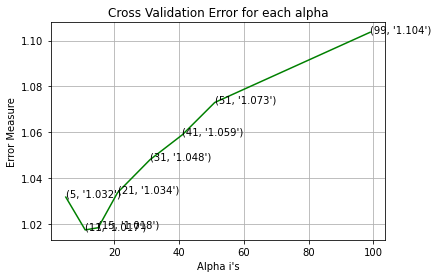

For values of best alpha:  11 The train log loss is:  0.6054024702223766
For values of best alpha:  11 The cross validation log loss is:  1.017345855674932
For values of best alpha:  11 The Test log loss is:  1.1130882119023289


In [72]:
#4.2 K Nearest Neighbour Classification
#4.2.1 Hyper Parameter Tuning
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("For Alpha: ",i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_,eps=1e-15))
    #to avoid rounding error while multiplying probabilities we use log-probability estimates
    print("Log Loss : ",log_loss(cv_y,sig_clf_probs))
fig, ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print("For values of best alpha: ",alpha[best_alpha],"The train log loss is: ",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print("For values of best alpha: ",alpha[best_alpha], "The cross validation log loss is: ",log_loss(y_cv,predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print("For values of best alpha: ",alpha[best_alpha],"The Test log loss is: ",log_loss(y_test, predict_y,labels=clf.classes_, eps=1e-15))

Log Loss:  1.017345855674932
Number of mis-classified points:  0.35150375939849626
-------------------- Confusion Matrix --------------------


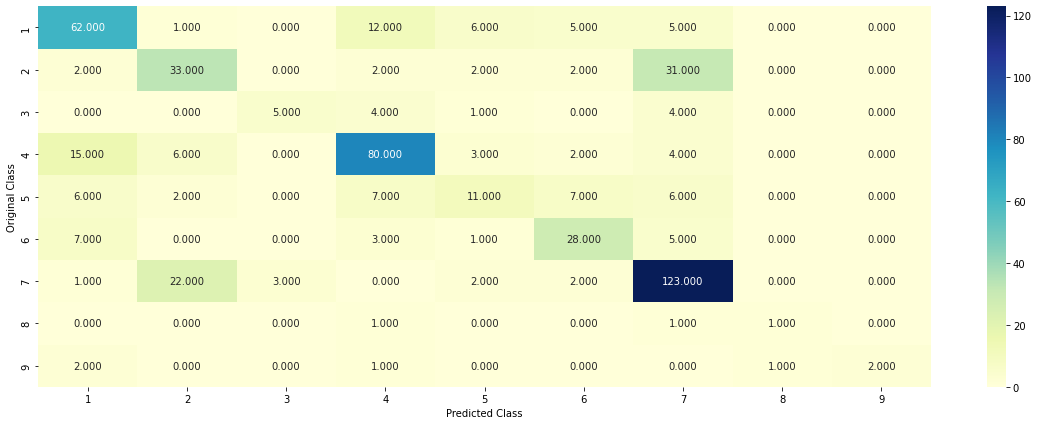

-------------------- Precision Matrix --------------------


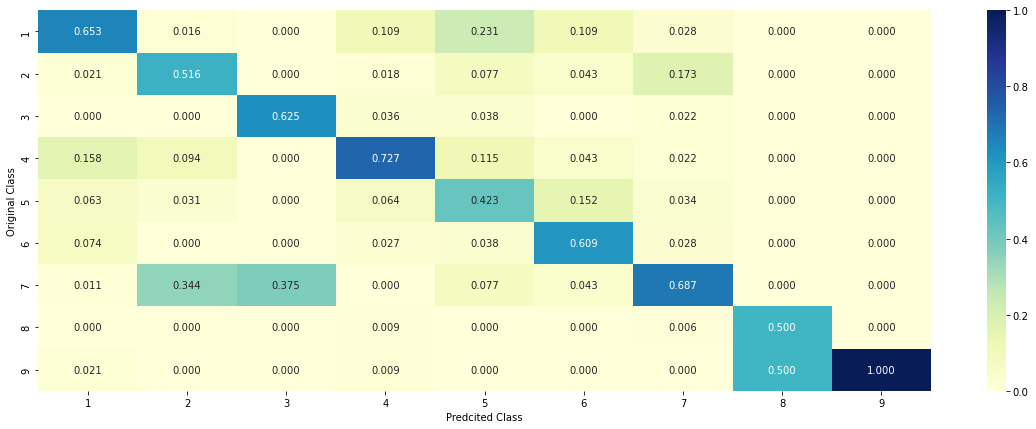

-------------------- Recall Matrix --------------------


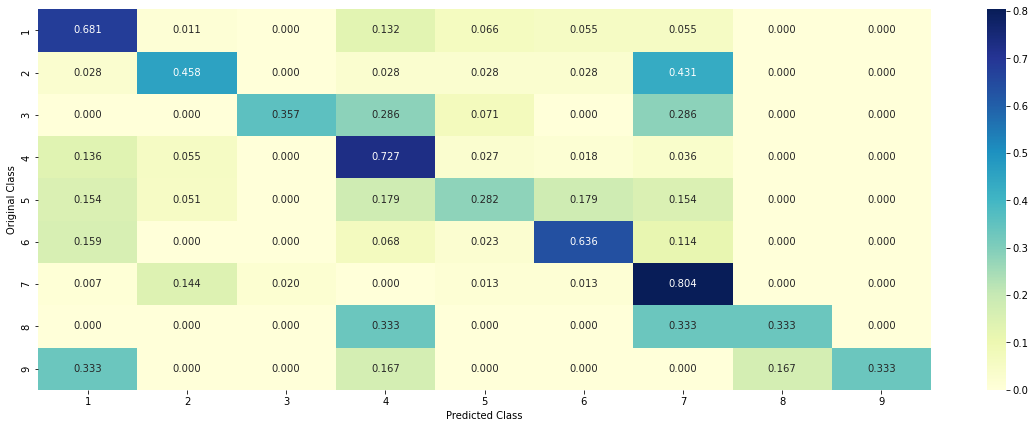

In [73]:
#4.2.2 Testing the model with best hyper parameters
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [74]:
#4.2.3 Sample Query Point -1
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 3
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class: ",predicted_cls[0])
print("Actual Class: ",test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The",alpha[best_alpha]," nearest neighbors of the test points belongs to classes",train_y[neighbors[1][0]])
print("Frequency of nearest points: ",Counter(train_y[neighbors[1][0]]))


Predicted Class:  4
Actual Class:  4
The 11  nearest neighbors of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 4]
Frequency of nearest points:  Counter({4: 11})


In [75]:
#4.2.4 Sample Query Point-2
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)
test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class: ",predicted_cls[0])
print("Actual Class: ",test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The K value for knn is: ",alpha[best_alpha],"and the nearest neighbors of the test points belongs to classes",train_y[neighbors[1][0]])
print("Frequency of nearest points: ",Counter(train_y[neighbors[1][0]]))

Predicted Class:  4
Actual Class:  5
The K value for knn is:  11 and the nearest neighbors of the test points belongs to classes [4 4 4 1 4 4 4 6 6 5 1]
Frequency of nearest points:  Counter({4: 6, 1: 2, 6: 2, 5: 1})


For alpha:  1e-06
Log loss:  1.278953294686581
For alpha:  1e-05
Log loss:  1.2370980089616515
For alpha:  0.0001
Log loss:  1.041846520818076
For alpha:  0.001
Log loss:  1.023184099319818
For alpha:  0.01
Log loss:  1.0873339885696982
For alpha:  0.1
Log loss:  1.421387179869117
For alpha:  1
Log loss:  1.6790030722237006
For alpha:  10
Log loss:  1.710589377921987
For alpha:  100
Log loss:  1.7138193933642414


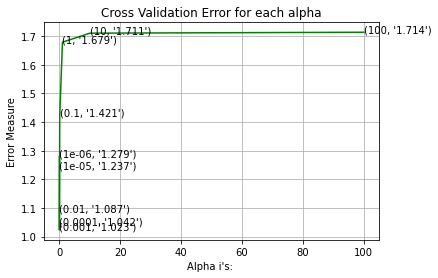

For Values of best alpha:  0.001 The Train log loss is:  0.5170158548947331
For values of best alpha:  0.001 The Cross Validation log loss is:  1.023184099319818
For values of best alpha:  0.001 The test log loss is:  1.157109952945836


In [76]:
#4.3 Logistic Regression
#4.3.1 With Class Balancing
#4.3.1.1 Hyper parameter tuning
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha: ",i)
    clf = SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilities we use log-probability estimates
    print("Log loss: ",log_loss(cv_y, sig_clf_probs))
fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's: ")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("For Values of best alpha: ",alpha[best_alpha],"The Train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The Cross Validation log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss:  1.023184099319818
Number of mis-classified points:  0.3383458646616541
-------------------- Confusion Matrix --------------------


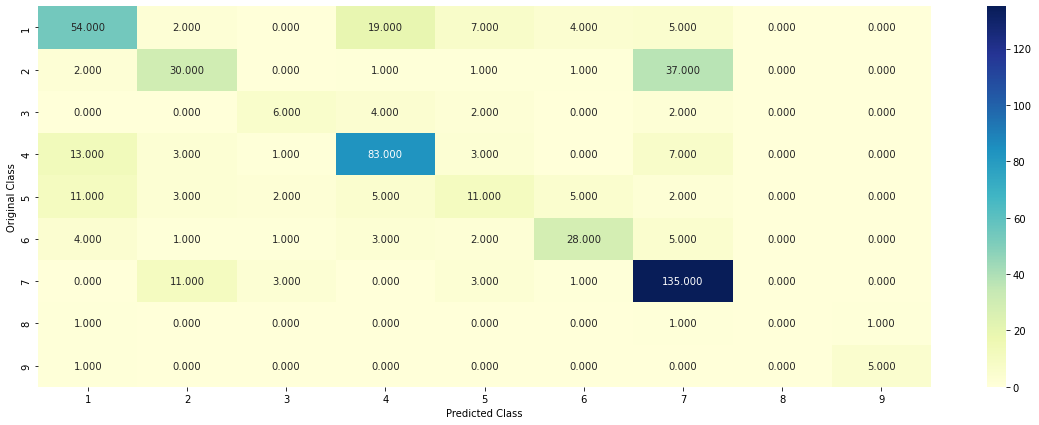

-------------------- Precision Matrix --------------------


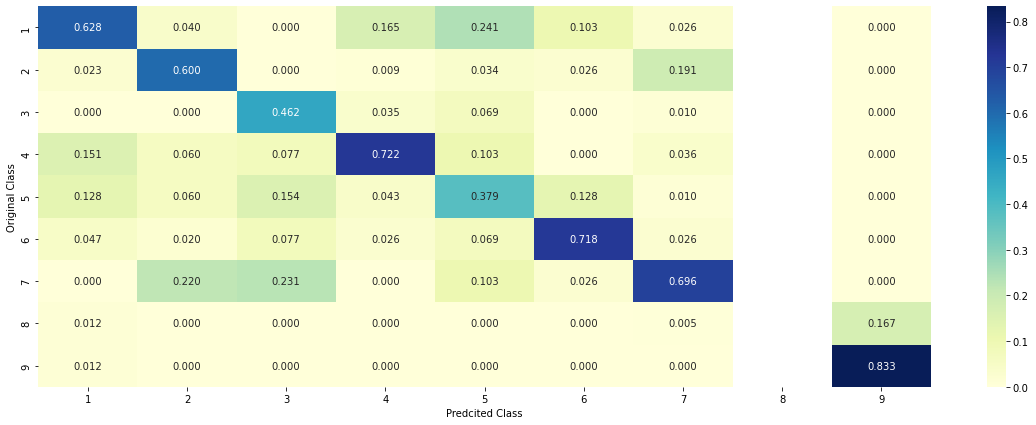

-------------------- Recall Matrix --------------------


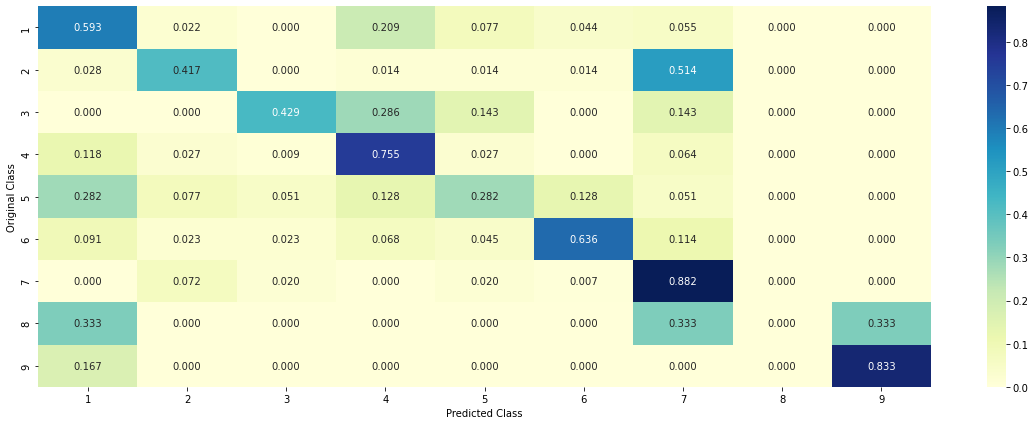

In [77]:
#4.3.1.2 Testing the model with best hyper parameter
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2',loss='log',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding,cv_y, clf)

In [78]:
#4.3.1.3 Feature Importance
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    increasingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([increasingorder_ind, "Gene", "Yes"])
        elif i < 18:
            tabulte_list.append([increasingorder_ind, "Variation", "Yes"])
        if ((i>17) & (i not in removed_ind)):
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([increasingorder_ind, train_text_features[i],yes_no])
        increasingorder_ind += 1
    print(word_present, "Most important features are present in our query point")
    print('-'*50)
    print("The features that are most important of the: ",predicted_cls[0],'Class: ')
    print(tabulate(tabulate_list, headers=["Index",'Feature name',"Present or Not"]))        

In [79]:
#4.3.1.3.1
#Correctly Classified Point
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],penalty='l2',loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_features = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class:  4
Predicted Class Probabilities:  [[0.2128 0.1061 0.0218 0.3449 0.0445 0.0382 0.2113 0.0079 0.0123]]
Actual Class:  4
--------------------------------------------------
Out of the top 100 features 0 are present in query point


In [80]:
#4.3.1.3.2 Incorrectly classified point
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_)) [predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class:  4
Predicted Class Probabilities:  [[0.123 0.04  0.011 0.612 0.081 0.073 0.045 0.007 0.007]]
Actual Class:  5
--------------------------------------------------
202 Text feature [302] present in the test data point [True]
299 Text feature [11b] present in the test data point [True]
368 Text feature [suppressor] present in the test data point [True]
375 Text feature [yph] present in the test data point [True]
487 Text feature [predisposition] present in the test data point [True]
497 Text feature [ura3] present in the test data point [True]
Out of the top 500 features 6 are present in query point


for alpha:  1e-06
Log Loss:  1.2570205049682723
for alpha:  1e-05
Log Loss:  1.1983759139514942
for alpha:  0.0001
Log Loss:  1.0479828811034948
for alpha:  0.001
Log Loss:  1.0467572126361386
for alpha:  0.01
Log Loss:  1.1664504628835142
for alpha:  0.1
Log Loss:  1.324713808438323
for alpha:  1
Log Loss:  1.5852818243569002


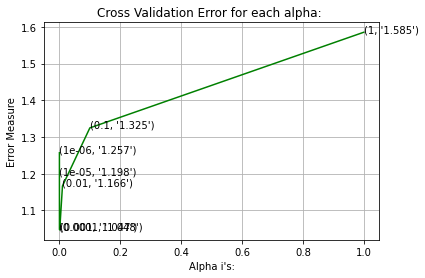

For values of best alpha=  0.001 The train log loss is:  0.5207614445626222
For values of best alpha:  0.001 The cross validation log loss is:  1.0467572126361386
For values of best alpha:  0.001 The test log loss is:  1.166588417274024


In [81]:
#4.3.2 Without Class Balancing
#4.3.2.1 Hyper Parameter Tuning
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha: ",i)
    clf = SGDClassifier(alpha=i,penalty='l2',loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss: ",log_loss(cv_y, sig_clf_probs))
fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i],str(txt)),(alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha: ")
plt.xlabel("Alpha i's:")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log',random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("For values of best alpha= ",alpha[best_alpha],'The train log loss is: ',log_loss(y_train, predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The cross validation log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("For values of best alpha: ",alpha[best_alpha],"The test log loss is: ",log_loss(test_y,predict_y,labels=clf.classes_,eps=1e-15))

Log Loss:  1.0467572126361386
Number of mis-classified points:  0.34774436090225563
-------------------- Confusion Matrix --------------------


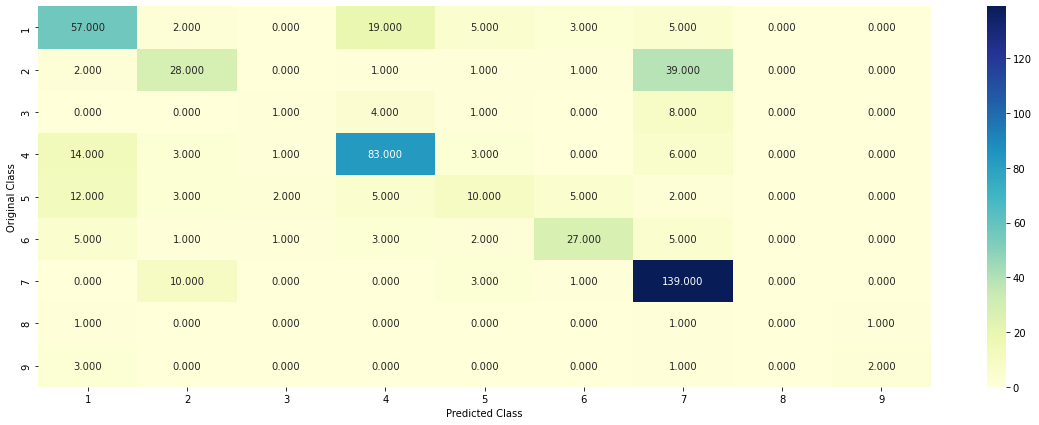

-------------------- Precision Matrix --------------------


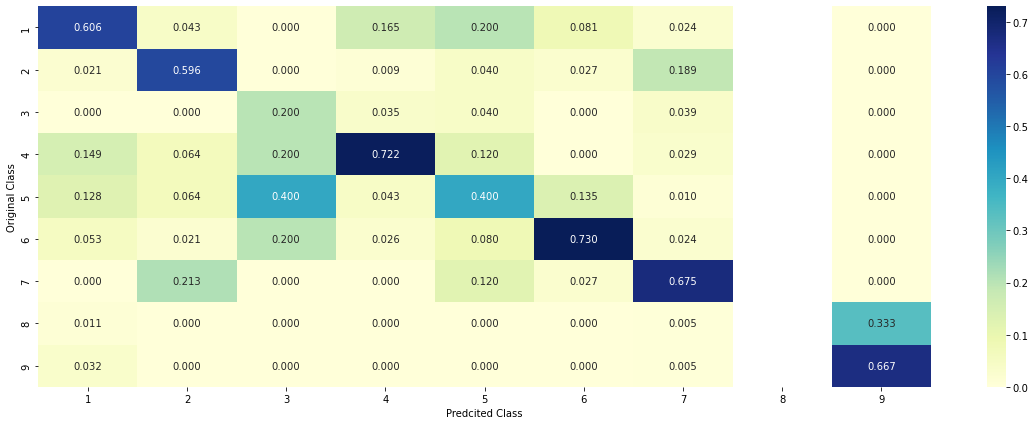

-------------------- Recall Matrix --------------------


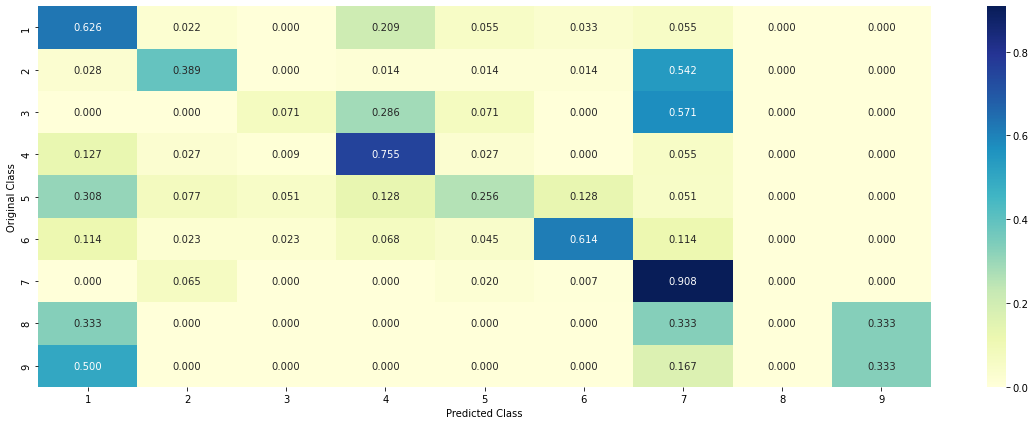

In [82]:
#4.3.2.2 Testing model with best hyperparameters
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [83]:
#4.3.2.3 Feature importance, Correctly Classified Points
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_features = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class:  4
Predicted Class probabilities:  [[0.2117 0.1105 0.0254 0.3398 0.0497 0.041  0.2009 0.0094 0.0115]]
Actual Class:  4
--------------------------------------------------
374 Text feature [11d] present in the test data point [True]
456 Text feature [biallelic] present in the test data point [True]
462 Text feature [suppressor] present in the test data point [True]
Out of the top 500 features 3 are present in query point


In [84]:
#4.3.2.4 Feature Importance, incorrectlyy classified Points
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print('-'*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class:  4
Predicted Class probabilities:  [[0.1195 0.0399 0.0136 0.6113 0.0809 0.0744 0.0482 0.0066 0.0056]]
Actual Class:  5
--------------------------------------------------
217 Text feature [302] present in the test data point [True]
325 Text feature [11b] present in the test data point [True]
432 Text feature [yph] present in the test data point [True]
453 Text feature [histidine] present in the test data point [True]
462 Text feature [suppressor] present in the test data point [True]
Out of the top 500 features 5 are present in query point


For C:  1e-05
Log Loss:  1.2430825218720492
For C:  0.0001
Log Loss:  1.1539015225754152
For C:  0.001
Log Loss:  1.0680393221078803
For C:  0.01
Log Loss:  1.1158940430010205
For C:  0.1
Log Loss:  1.3201818273202188
For C:  1
Log Loss:  1.700241059659092
For C:  10
Log Loss:  1.714319189810373
For C:  100
Log Loss:  1.7143252366255863


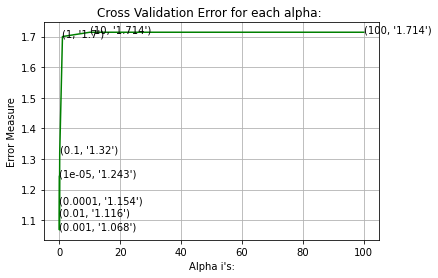

For values of best alpha 0.001 The train log loss is:  0.5355086916878161
For values of best alpha 0.001 The cross validation log loss is:  1.0680393221078803
For values of alpha:  0.001 The test log loss is:  1.2136683469951721


In [85]:
#4.4 Linear Support Vector Machines
#4.4.1 Hyper Parameter tuning
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("For C: ",i)
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2',loss='hinge',random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss: ",log_loss(cv_y, sig_clf_probs))
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha: ")
plt.xlabel("Alpha i's:")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2',loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("For values of best alpha",alpha[best_alpha],'The train log loss is: ',log_loss(train_y, predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("For values of best alpha",alpha[best_alpha],"The cross validation log loss is: ",log_loss(cv_y, predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("For values of alpha: ",alpha[best_alpha],"The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_,eps=1e-15))

Log Loss:  1.0680393221078803
Number of mis-classified points:  0.34022556390977443
-------------------- Confusion Matrix --------------------


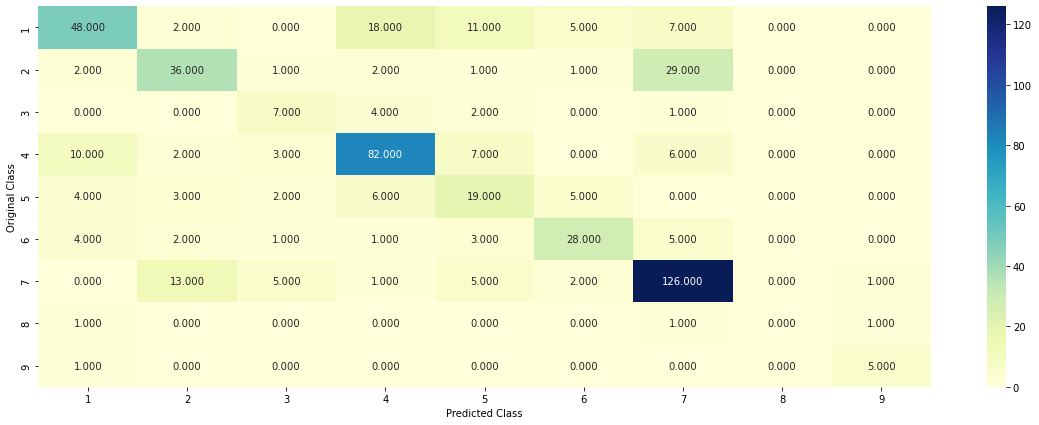

-------------------- Precision Matrix --------------------


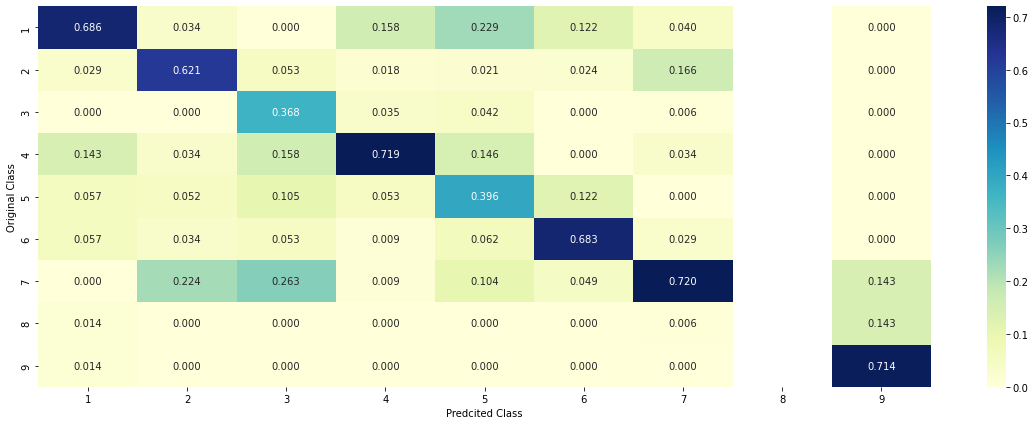

-------------------- Recall Matrix --------------------


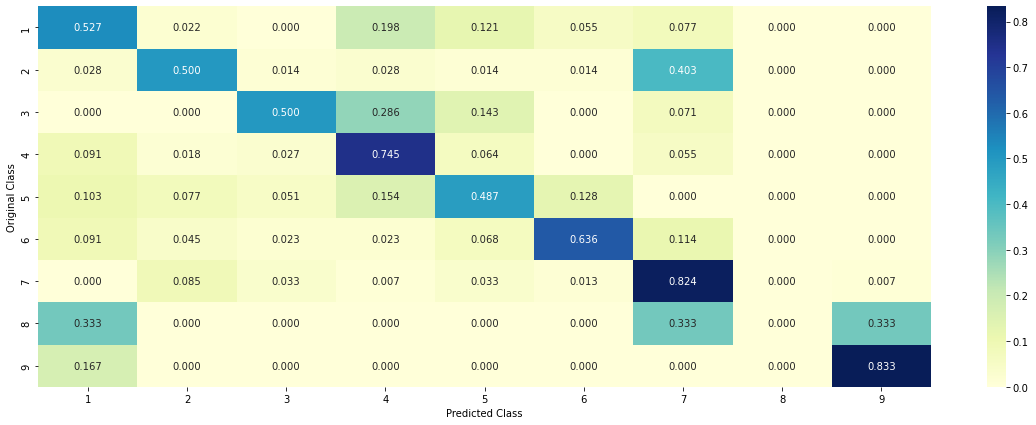

In [86]:
#4.4.2 Testing model with best hyper parameter
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding,train_y,cv_x_onehotCoding,cv_y,clf)

In [87]:
#4.3.3 Feature importance
#4.3.3.1 For Correctly classified points
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted class: ",predicted_cls[0])
print("Actual class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_features]
print('*_*  '*20)
get_impfeature_names(indices[0],test_df["TEXT"].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted class:  4
Actual class:  4
*_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  *_*  
400 Text feature [transported] present in the test data point [True]
498 Text feature [biallelic] present in the test data point [True]
Out of the top 500 features 2 are present in query point


In [88]:
#4.3.3.2 For Incorrectly classified Points
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("_-_-"*10)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class:  4
Predicted Class probabilities:  [[0.0744 0.0653 0.0031 0.5806 0.0758 0.0849 0.1035 0.0059 0.0066]]
Actual Class:  5
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Out of the top 100 features 0 are present in query point


In [89]:
#4.5 Random Forest Classifier
#4.5.1 Hyper parameter tuning (With one hot encoding)
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators= ",i,"and max depth = ",j)
        clf = RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss: ",log_loss(cv_y, sig_clf_probs))
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini',max_depth=max_depth[int(best_alpha%2)],random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("For Values of best estimator=: ",alpha[int(best_alpha/2)], "The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("For value of best estimators: ",alpha[int(best_alpha/2)],"The Cross Validation log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("For values of best estimaors: ",alpha[int(best_alpha/2)],"The Test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators=  100 and max depth =  5
Log Loss:  1.2352145724607755
for n_estimators=  100 and max depth =  10
Log Loss:  1.1644420649010936
for n_estimators=  200 and max depth =  5
Log Loss:  1.2196596733328966
for n_estimators=  200 and max depth =  10
Log Loss:  1.1504455625504033
for n_estimators=  500 and max depth =  5
Log Loss:  1.2139797842717792
for n_estimators=  500 and max depth =  10
Log Loss:  1.1413968959837175
for n_estimators=  1000 and max depth =  5
Log Loss:  1.2071090693230635
for n_estimators=  1000 and max depth =  10
Log Loss:  1.1384263319670018
for n_estimators=  2000 and max depth =  5
Log Loss:  1.2079641886155144
for n_estimators=  2000 and max depth =  10
Log Loss:  1.139339647503249
For Values of best estimator=:  1000 The train log loss is:  0.6922635495639177
For value of best estimators:  1000 The Cross Validation log loss is:  1.1384263319670018
For values of best estimaors:  1000 The Test log loss is:  1.207716451713174


Log Loss:  1.1384263319670018
Number of mis-classified points:  0.38345864661654133
-------------------- Confusion Matrix --------------------


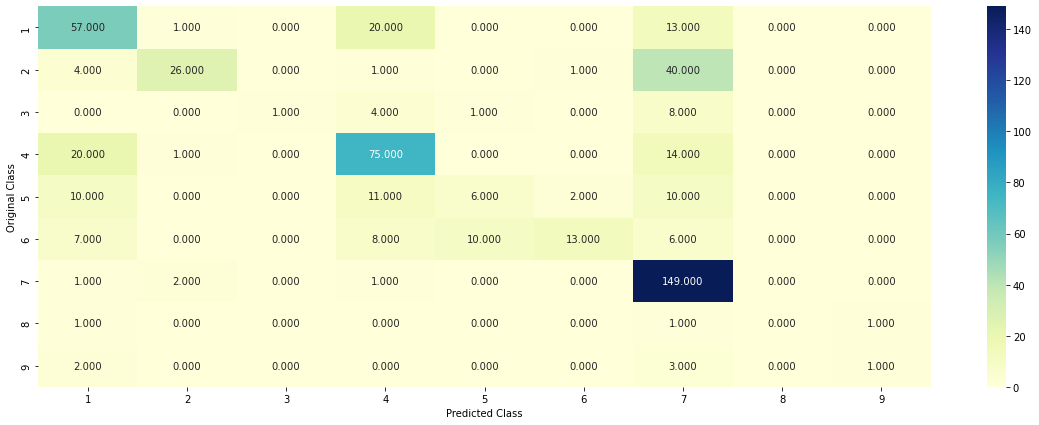

-------------------- Precision Matrix --------------------


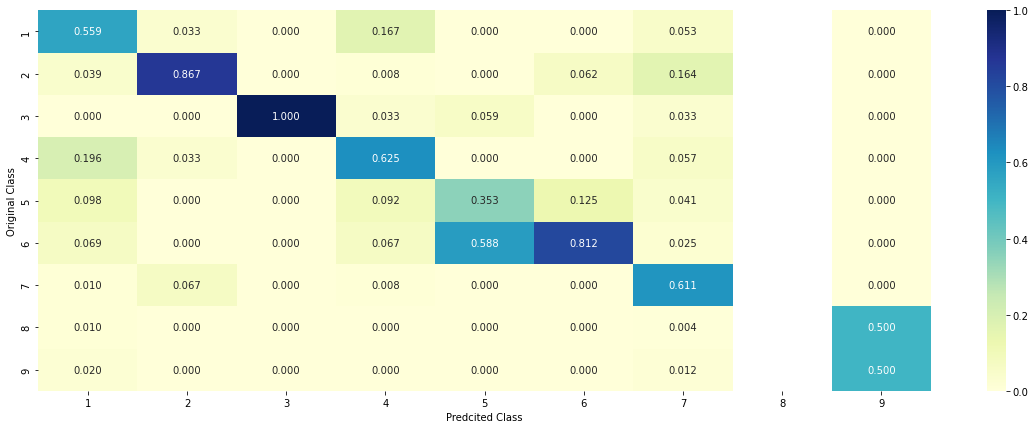

-------------------- Recall Matrix --------------------


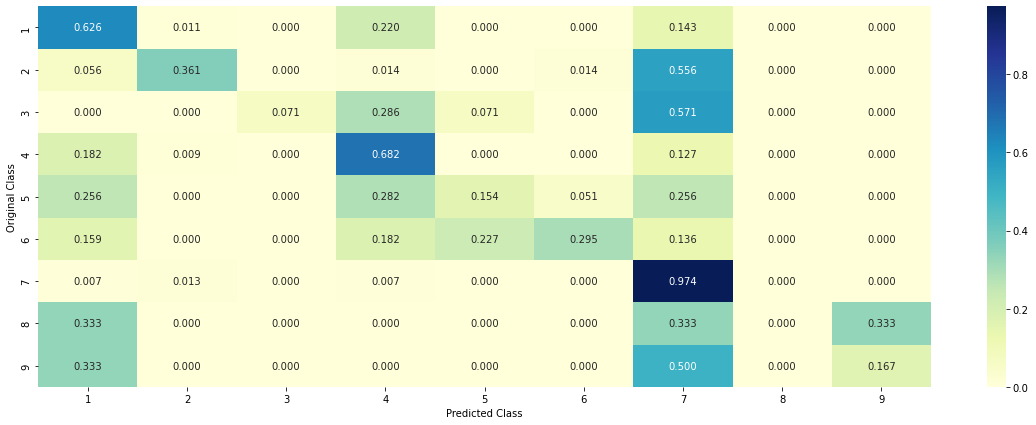

In [90]:
#4.5.2 Testing Model with best hyperparameter(one_hot_Coding)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth = max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [91]:
#4.5.3 Feature Importance
#4.5.3.1 Correctly Classified Point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature],test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class:  4
Predicted Class Probabilities:  [[0.311 0.104 0.024 0.312 0.062 0.05  0.114 0.009 0.013]]
Actual Class:  4
--------------------------------------------------
1 Text feature [activated] present in the test data point [True]
9 Text feature [suppressor] present in the test data point [True]
10 Text feature [function] present in the test data point [True]
12 Text feature [inhibitor] present in the test data point [True]
13 Text feature [treatment] present in the test data point [True]
18 Text feature [oncogenic] present in the test data point [True]
19 Text feature [growth] present in the test data point [True]
20 Text feature [brca1] present in the test data point [True]
22 Text feature [downstream] present in the test data point [True]
24 Text feature [cells] present in the test data point [True]
27 Text feature [functional] present in the test data point [True]
28 Text feature [loss] present in the test data point [True]
33 Text feature [patients] present in the test

In [92]:
#4.5.3.2 Incorrectly Classified Point
test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],no_feature)

Predicted Class:  4
Predicted Class Probabilities:  [[0.2202 0.0694 0.0308 0.457  0.0612 0.0492 0.0944 0.0078 0.01  ]]
Actual Class:  3
--------------------------------------------------
0 Text feature [kinase] present in the test data point [True]
2 Text feature [activating] present in the test data point [True]
4 Text feature [missense] present in the test data point [True]
5 Text feature [phosphorylation] present in the test data point [True]
6 Text feature [activation] present in the test data point [True]
7 Text feature [inhibitors] present in the test data point [True]
10 Text feature [function] present in the test data point [True]
11 Text feature [constitutive] present in the test data point [True]
15 Text feature [signaling] present in the test data point [True]
19 Text feature [growth] present in the test data point [True]
22 Text feature [downstream] present in the test data point [True]
23 Text feature [constitutively] present in the test data point [True]
24 Text feature [

In [93]:
#4.5.3 Hyper Parameter Tuning(With Response Coding)
alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print('for n_estimators= ',i,'and max depth',j)
        clf = RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,random_state = 42, n_jobs=-1)
        clf.fit(train_x_responseCoding,train_y)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_,eps=1e-15))
        print("Log Loss: ",log_loss(cv_y, sig_clf_probs))
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini',max_depth=max_depth[int(best_alpha%4)],random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print("For values of best alpha: ",alpha[int(best_alpha/4)],"The Train log loss is: ",log_loss(y_train,predict_y,labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print("For values of best alpha: ",alpha[int(best_alpha/4)],"The Cross Validation log loss is: ",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print("For Values of best alpha: ",alpha[int(best_alpha/4)],"The test log loss is: ",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

for n_estimators=  10 and max depth 2
Log Loss:  2.143221815055429
for n_estimators=  10 and max depth 3
Log Loss:  1.641932087354153
for n_estimators=  10 and max depth 5
Log Loss:  1.4032596877828012
for n_estimators=  10 and max depth 10
Log Loss:  1.5521365978863981
for n_estimators=  50 and max depth 2
Log Loss:  1.6512440164273496
for n_estimators=  50 and max depth 3
Log Loss:  1.4274993881829408
for n_estimators=  50 and max depth 5
Log Loss:  1.3222120328083509
for n_estimators=  50 and max depth 10
Log Loss:  1.4923045702795517
for n_estimators=  100 and max depth 2
Log Loss:  1.5069586201008303
for n_estimators=  100 and max depth 3
Log Loss:  1.4702351523632275
for n_estimators=  100 and max depth 5
Log Loss:  1.2483564099050937
for n_estimators=  100 and max depth 10
Log Loss:  1.4779252292093055
for n_estimators=  200 and max depth 2
Log Loss:  1.5333541759080385
for n_estimators=  200 and max depth 3
Log Loss:  1.4719245903207039
for n_estimators=  200 and max depth 5
Lo

Log Loss:  1.2483564099050937
Number of mis-classified points:  0.46616541353383456
-------------------- Confusion Matrix --------------------


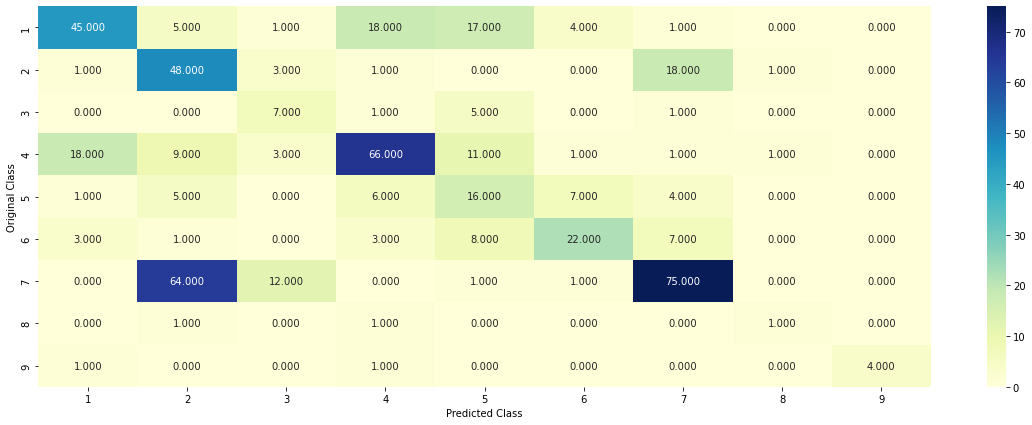

-------------------- Precision Matrix --------------------


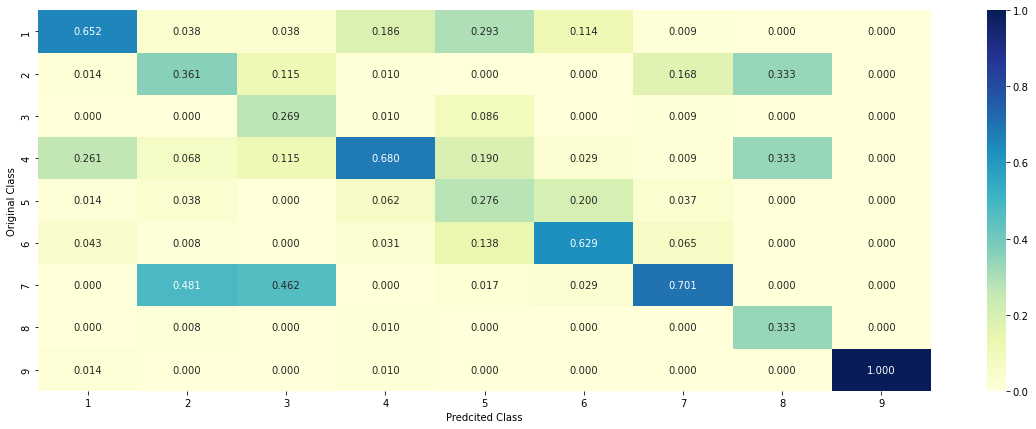

-------------------- Recall Matrix --------------------


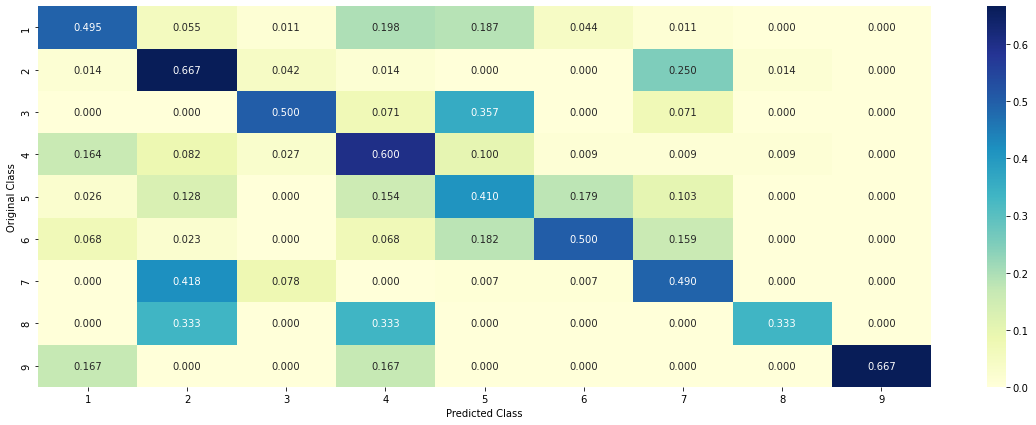

In [94]:
#4.5.4 Testing model with best hyper parameter
#responseCoding
clf =RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)],criterion='gini', max_features='auto', random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [95]:
#4.5.5 Feature Importance
#4.5.5.1  Correctly classified point
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)],criterion='gini',max_depth=max_depth[int(best_alpha%4)],random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
np_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class: ",predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1, -1)),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")
    

Predicted Class:  4
Predicted Class Probabilities:  [[0.2646 0.0264 0.1196 0.4162 0.0314 0.0427 0.0088 0.0443 0.0461]]
Actual Class:  4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [96]:
#4.5.5.2 Incorrectly Classified Points
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class: ", predicted_cls[0])
print("Predicted Class Probabilities: ",np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class: ",test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class:  5
Predicted Class Probabilities:  [[0.1125 0.0125 0.1286 0.1407 0.3454 0.2277 0.0064 0.0111 0.0152]]
Actual Class:  5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [98]:
#4.7 Stack the model
#4.7.1 Testing with best hyper parameter
clf1 = SGDClassifier(alpha=0.001, penalty='l2',loss='log',class_weight='balanced',random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method='sigmoid')

clf2 = SGDClassifier(alpha=1, penalty='l2',loss='hinge',class_weight='balanced',random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2,method='sigmoid')

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding,train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method='sigmoid')

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression: Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support Vector: Log Loss: %0.2f" % (log_loss(cv_y,sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes: Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifier: For the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression: Log Loss: 1.02
Support Vector: Log Loss: 1.70
Naive Bayes: Log Loss: 1.24
--------------------------------------------------
Stacking Classifier: For the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifier: For the value of alpha: 0.001000 Log Loss: 1.719
Stacking Classifier: For the value of alpha: 0.010000 Log Loss: 1.312
Stacking Classifier: For the value of alpha: 0.100000 Log Loss: 1.130
Stacking Classifier: For the value of alpha: 1.000000 Log Loss: 1.359
Stacking Classifier: For the value of alpha: 10.000000 Log Loss: 1.680


Log Loss (train) on the stacking classifier:  0.49969887633594035
Log Loss on (Cross Validation) on the Stacking classifier 1.129556126835277
Log Loss on (test) data on the stacking classifier:  1.2223198219848597
Number of misclassified point 0.3593984962406015
-------------------- Confusion Matrix --------------------


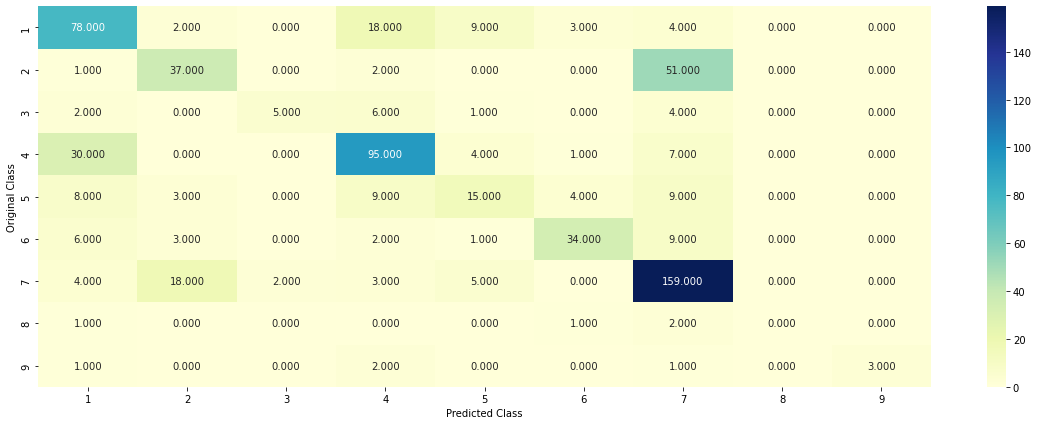

-------------------- Precision Matrix --------------------


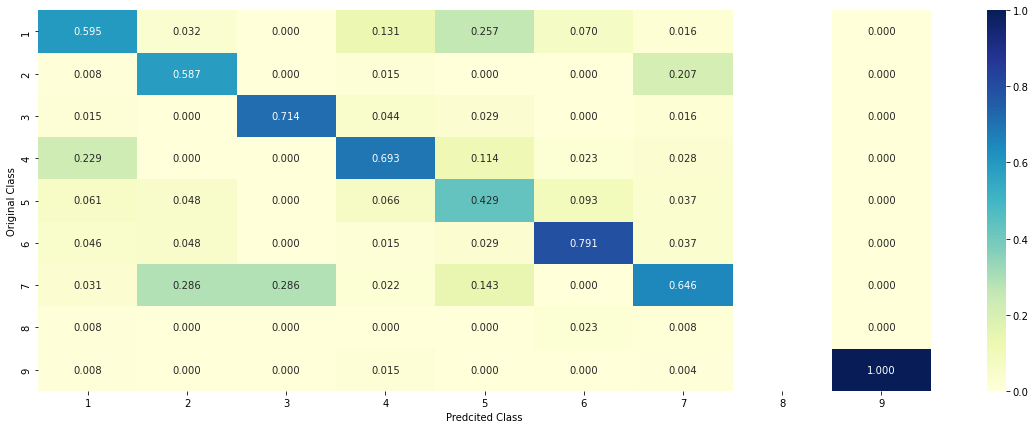

-------------------- Recall Matrix --------------------


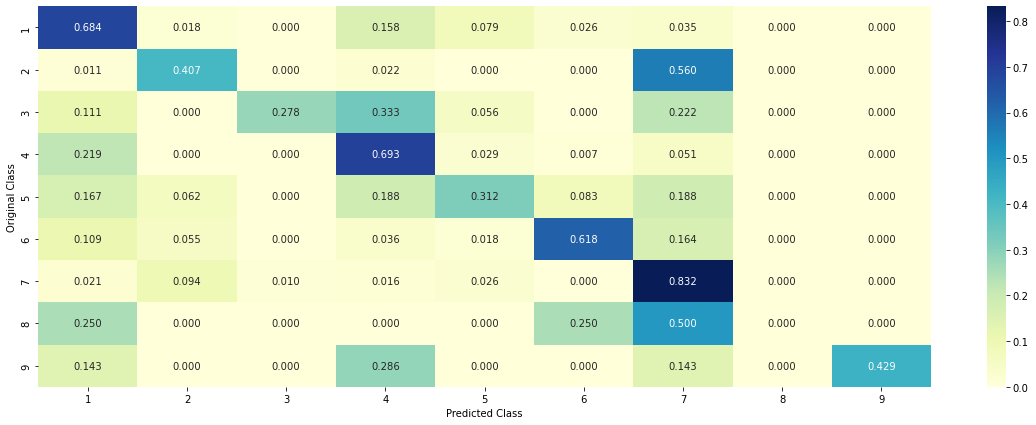

In [100]:
#4.7.2 Testing the model with best hyper parameters
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)
log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log Loss (train) on the stacking classifier: ",log_error)
log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log Loss on (Cross Validation) on the Stacking classifier",log_error)
log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log Loss on (test) data on the stacking classifier: ",log_error)

print("Number of misclassified point",np.count_nonzero((sclf.predict(test_x_onehotCoding)-test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log Loss (train) on the Voting Classifier:  0.8563419287493206
Log Loss (CV) on the Voting Classifier:  1.1575653881313486
Log Loss (Test) on the Voting Classifier:  1.2187651507650237
Number of missclassified point:  0.3593984962406015
-------------------- Confusion Matrix --------------------


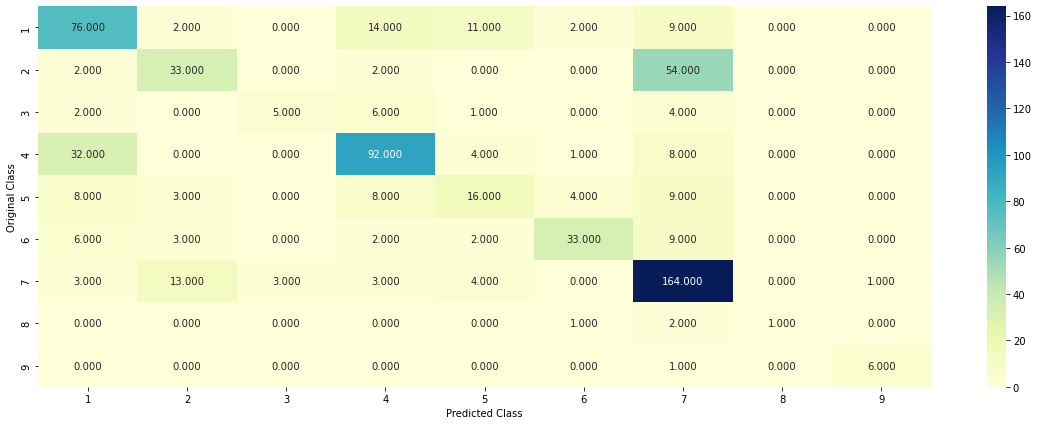

-------------------- Precision Matrix --------------------


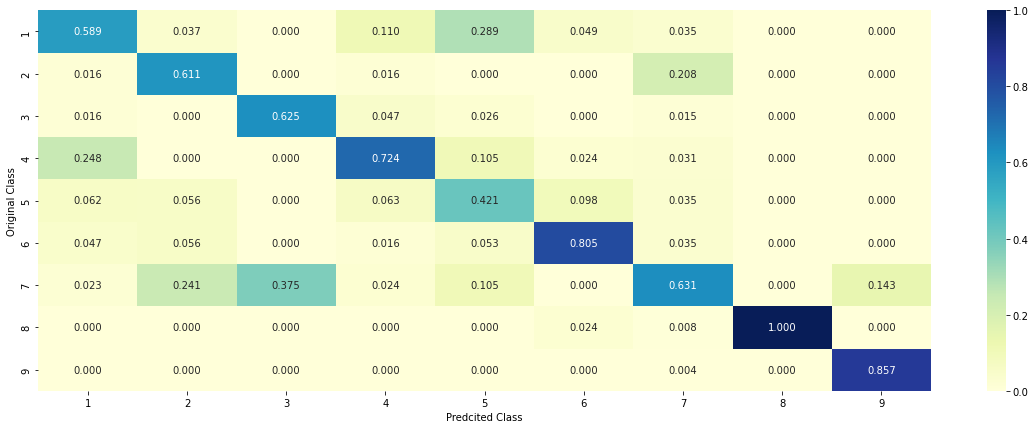

-------------------- Recall Matrix --------------------


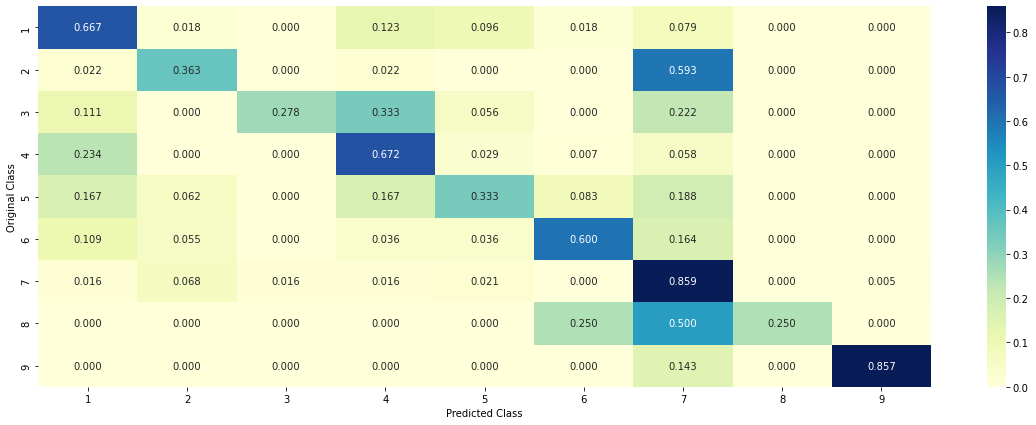

In [101]:
#4,7.3 Maximum Voting Classifier
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1),('svc',sig_clf2),('rf',sig_clf3)],voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log Loss (train) on the Voting Classifier: ",log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log Loss (CV) on the Voting Classifier: ",log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log Loss (Test) on the Voting Classifier: ",log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point: ",np.count_nonzero((vclf.predict(test_x_onehotCoding)-test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))